# Customer Analysis - Part 3

## Importing and general cleaning

Import the libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### We define a series of functions for our data cleaning pipe:

In [37]:
#Function for reading the data:
def read_customer_data():
    return pd.read_csv("Data_Marketing_Customer_Analysis_Round2.txt")


In [38]:
#Function for standardizing column names:
def standardize(df):
    new_columns = df.columns.str.lower().str.replace(" ", "_")
    df.columns = new_columns
    return df

In [39]:
#Function for dropping customer and unnamed:_0 columns
def drop_2cols(df):
    df.drop(columns=["unnamed:_0", "customer"], inplace=True)
    return df

In [40]:
#Drop duplicates and reset index
def dd(df):
    df = df.drop_duplicates().reset_index()
    df.drop(columns=["index"], inplace=True)
    return df

In [41]:
#Replacing null values
def fill_null(df):
    df["number_of_open_complaints"] = df["number_of_open_complaints"].fillna(value=0)
    mean_months = round(df["months_since_last_claim"].mean())
    df["months_since_last_claim"] = df["months_since_last_claim"].fillna(value=mean_months)
    mean_income = round(df["income"].mean())
    df["income"] = df["income"].fillna(value=mean_income)
    return df

## Running the pipe!!

In [42]:
df = read_customer_data().pipe(standardize).pipe(drop_2cols).pipe(dd).pipe(fill_null)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10776 entries, 0 to 10775
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          10163 non-null  object 
 1   customer_lifetime_value        10776 non-null  float64
 2   response                       10163 non-null  object 
 3   coverage                       10776 non-null  object 
 4   education                      10776 non-null  object 
 5   effective_to_date              10776 non-null  object 
 6   employmentstatus               10776 non-null  object 
 7   gender                         10776 non-null  object 
 8   income                         10776 non-null  int64  
 9   location_code                  10776 non-null  object 
 10  marital_status                 10776 non-null  object 
 11  monthly_premium_auto           10776 non-null  int64  
 12  months_since_last_claim        10776 non-null 

# Activity 4 - visualization

1. Show a plot of the total number of responses.
2. Show a plot of the response rate by the sales channel.
3. Show a plot of the response rate by the total claim amount.
4. Show a plot of the response rate by income.
5. Don't Limit your creativity! plot Any interesting findings/insights that describe some interesting facts about your data set and its variables. Use the relevant plotting when you feel it is needed.
6. Plot the Correlation Heatmap.
7. Clean your notebook and make it a readible and presentable with a good documentation that summarizes the Data Cleaning, Exploration(including plots) Steps that you have performed.

### 1. Show a plot of the total number of responses

<BarContainer object of 2 artists>

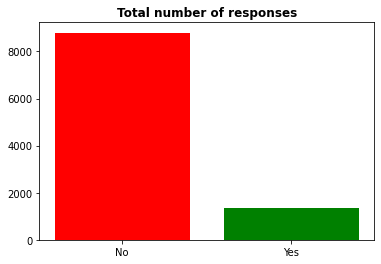

In [87]:
response = df["response"].value_counts()
fig, ax = plt.subplots()
ax.set_title("Total number of responses", fontweight="bold")
ax.bar(response.index, response,color=("red","green"))

We can see that the vast majority of responses are negative

### 2. Show a plot of the response rate by the sales channel.


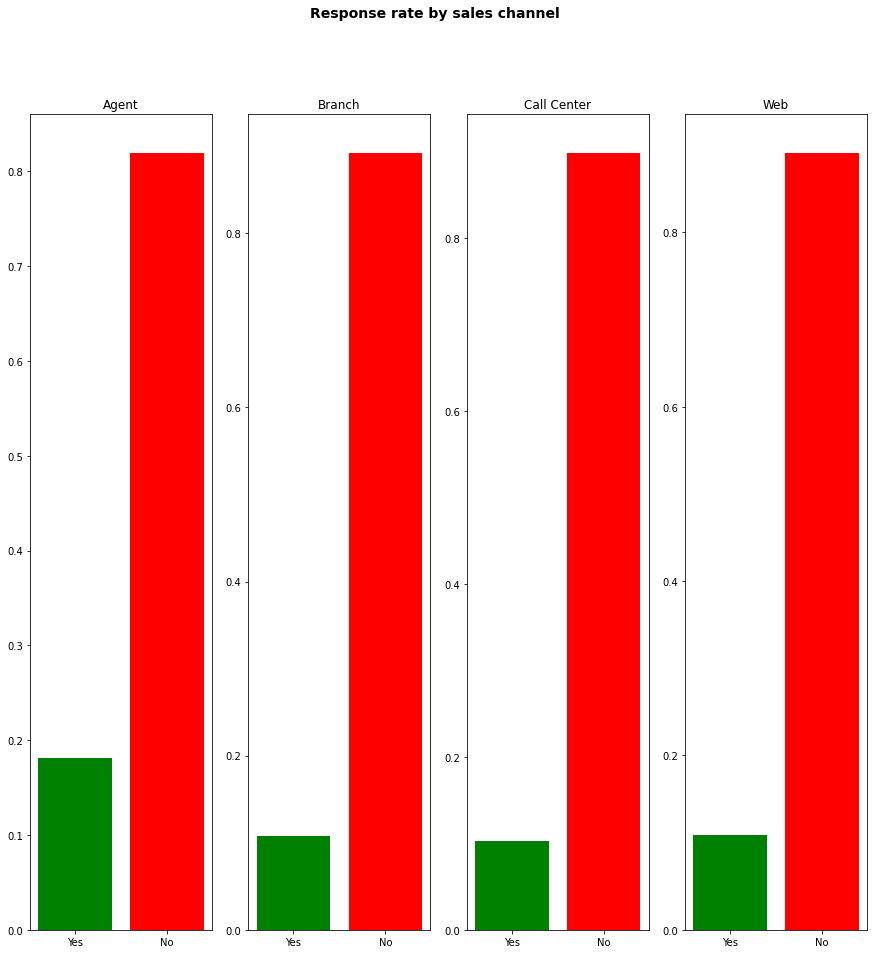

In [278]:
channel = df.groupby("sales_channel")

#We create a series with the total responses (that are not NaN) per channel
totals_channel = channel["response"].count()

#Iterate through the groups to create a dictionary with all the information we need
dic = {}
for group, sub_df in channel:
    dic[group] = {"Yes": sub_df.loc[sub_df["response"] == "Yes", "response"].count(),
                 "No": sub_df.loc[sub_df["response"] == "No", "response"].count(),
                 "Total": totals_channel[group]}

#We create the bars of the graph:
names = [key for key in dic.keys()]
bars = []

for key in names:
    bars.append([dic[key]["Yes"]/dic[key]["Total"],
                dic[key]["No"]/dic[key]["Total"]])

#We finally create the graph:

fig2, ax2 = plt.subplots(1,4, figsize=(15,15))
fig2.suptitle('Response rate by sales channel', size='14', fontweight='bold')

for index, name in enumerate(names):
    ax2[index].set_title(f"{name}")
    ax2[index].bar(["Yes", "No"], bars[index], color=("green", "red"))


The most effective sales channel is the branch, with almost a 20% of success rate. The others have a similar success rate, aroun 10%. It would be interesting to know the cost/client_contacted for each channel, to adequately analyze the efficiency of the channels.

### 3. Show a plot of the response rate by the total claim amount.

['0 - 579', '579 - 1157', '1157 - 1736', '1736 - 2315', '2315 - 2893']
[578.6281342, 1157.2562684, 1735.8844026, 2314.5125368, 2893.140671]
{0: {'Yes': 1122, 'No': 6873, 'Total': 7995}, 1: {'Yes': 211, 'No': 1660, 'Total': 1871}, 2: {'Yes': 35, 'No': 212, 'Total': 247}, 3: {'Yes': 0, 'No': 43, 'Total': 43}, 4: {'Yes': 0, 'No': 7, 'Total': 7}}
[[1122, 6873], [211, 1660], [35, 212], [0, 43], [0, 7]]


C:\Users\carlo\AppData\Local\Temp/ipykernel_15644/1364337760.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_claims["classification"] = df_claims["total_claim_amount"].apply(class_function)


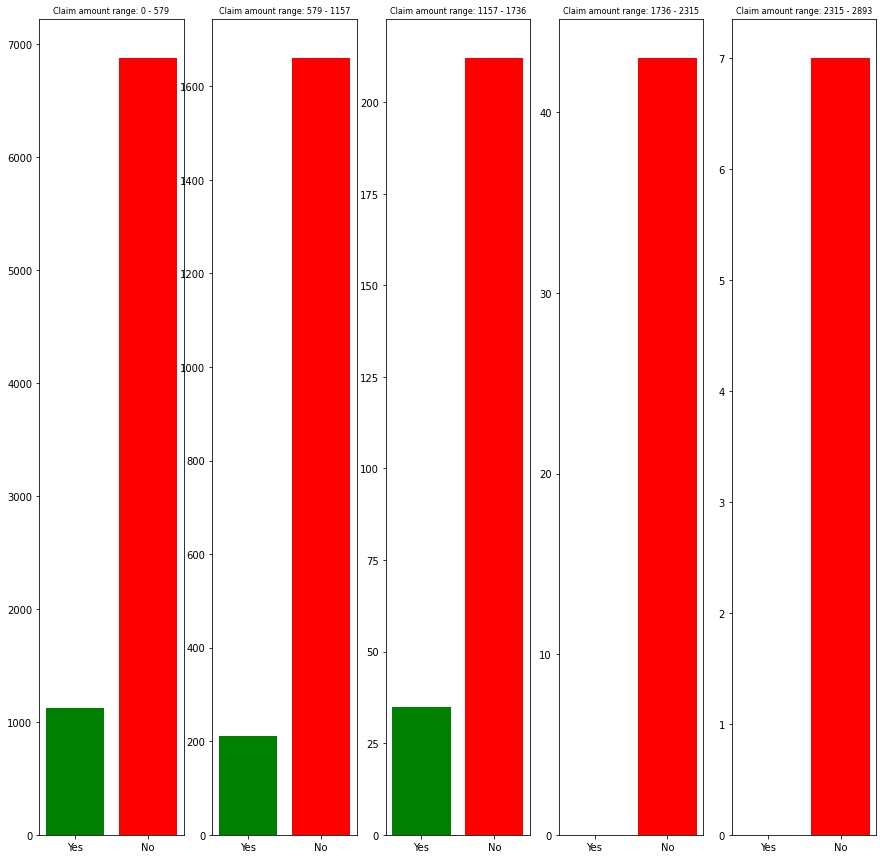

In [332]:
#We create 5 intervals to classify each entry as a function of their total claim amount:
max_distance = df["total_claim_amount"].max() - df["total_claim_amount"].min()
interval = max_distance/5
intervals_names = []
intervals_max = []

for i in range(5):
    intervals_names.append(f"{i*interval:.0f} - {(i+1)*interval:.0f}")
    intervals_max.append((i+1)*interval)
print(intervals_names)
print(intervals_max)

#We create a new DF that has a column with the classification according to the total claim amount
#For that, we create a classification function:
def class_function(x):
    if x!=x:
        return x
    for i in range(3,-1,-1):
        if x >= intervals_max[i]:
            return i + 1
    return 0

#Now we apply the classification function to add the new columns
df_claims = df[["total_claim_amount", "response"]]
df_claims["classification"] = df_claims["total_claim_amount"].apply(class_function)

#Now we group by the classification, and we add the customers that respond yes and no:
claims_groups = df_claims.groupby("classification")

#We iterate thorugh the groups to fill the dictionary with the Yes and No per class:
i = 0
dic={}
for group, sub_df in claims_groups:
    yes = sub_df.loc[sub_df["response"] == "Yes", "response"].count()
    no = sub_df.loc[sub_df["response"] == "No", "response"].count()
    dic[i] = {"Yes": yes, "No": no, "Total": yes+no}
    i+=1

#We create the bars of the graph:
bars = []
for i in range(len(intervals_names)):
    bars.append([dic[i]["Yes"],
                dic[i]["No"]])

#With al the data we need, we can plot the figure, like in the last occasion:

fig3, ax3 = plt.subplots(1,len(intervals_names), figsize=(15,15))
fig2.suptitle('Response rate per total claim amount interval', size='14', fontweight='bold')

for index, name in enumerate(intervals_names):
    ax3[index].set_title(f"Claim amount range: {name}", size='8')
    ax3[index].bar(["Yes", "No"], bars[index], color=("green", "red"))


The clients with a claim amount over 1736 never actually responde yes to an offer. Probably because they are not very happy about their insurance company.

### 4. Show a plot of the response rate by income.

['0 - 19996', '19996 - 39992', '39992 - 59989', '59989 - 79985', '79985 - 99981']
[19996.2, 39992.4, 59988.600000000006, 79984.8, 99981.0]


C:\Users\carlo\AppData\Local\Temp/ipykernel_15644/3884888096.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_claims["classification_inc"] = df_claims["income"].apply(class_function)


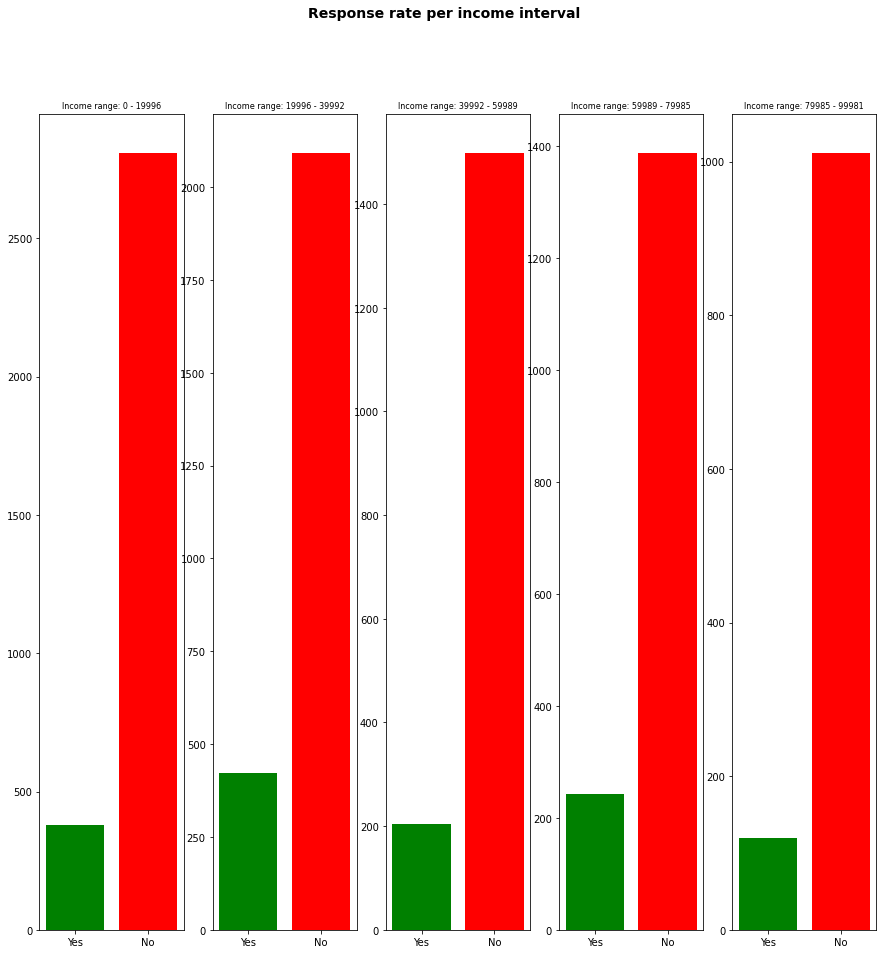

In [334]:
#We create 5 intervals to classify each entry as a function of their income:
max_distance = df["income"].max() - df["income"].min()
interval = max_distance/5
intervals_names = []
intervals_max = []

for i in range(5):
    intervals_names.append(f"{i*interval:.0f} - {(i+1)*interval:.0f}")
    intervals_max.append((i+1)*interval)
print(intervals_names)
print(intervals_max)

#We create a new DF that has a column with the classification according to the income
#For that, we create a classification function:
def class_function(x):
    if x!=x:
        return x
    for i in range(3,-1,-1):
        if x >= intervals_max[i]:
            return i + 1
    return 0

#Now we apply the classification function to add the new columns
df_claims = df[["income", "response"]]
df_claims["classification_inc"] = df_claims["income"].apply(class_function)

#Now we group by the classification, and we add the customers that respond yes and no:
claims_groups = df_claims.groupby("classification_inc")

#We iterate thorugh the groups to fill the dictionary with the Yes and No per class:
i = 0
dic={}
for group, sub_df in claims_groups:
    yes = sub_df.loc[sub_df["response"] == "Yes", "response"].count()
    no = sub_df.loc[sub_df["response"] == "No", "response"].count()
    dic[i] = {"Yes": yes, "No": no, "Total": yes+no}
    i+=1

#We create the bars of the graph:
bars = []
for i in range(len(intervals_names)):
    bars.append([dic[i]["Yes"],
                dic[i]["No"]])

#With al the data we need, we can plot the figure, like in the last occasion:

fig4, ax4 = plt.subplots(1,len(intervals_names), figsize=(15,15))
fig4.suptitle('Response rate per income interval', size='14', fontweight='bold')

for index, name in enumerate(intervals_names):
    ax4[index].set_title(f"Income range: {name}", size='8')
    ax4[index].bar(["Yes", "No"], bars[index], color=("green", "red"))


People with a medium-lower income range (some income, but not much) seem more likely to respond positively to the campaign.

### 6. Plot the Correlation Heatmap

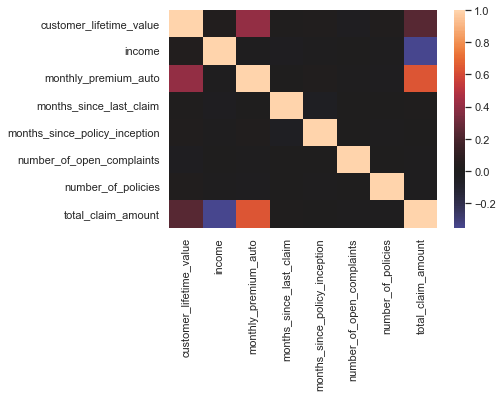

In [343]:
sns.set_theme()
ax = sns.heatmap(df._get_numeric_data().corr(), center=0)


The biggest correlation is between the monthly premium and the total claimed amount. It is logical, since the more the premium, the larger the insured amount and, thus, probably the total claimed amount.